[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train RF-DETR Object Detection on a Custom Dataset

---

[![hf space](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/SkalskiP/RF-DETR)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-finetune-rf-detr-on-detection-dataset.ipynb)
[![roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/rf-detr)
[![code](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/rf-detr)

RF-DETR is a real-time transformer architecture for object detection and instance segmentation developed by Roboflow. Built on a DINOv2 vision transformer backbone, RF-DETR delivers state-of-the-art accuracy and latency trade-offs on [Microsoft COCO](https://cocodataset.org/#home) and [RF100-VL](https://github.com/roboflow/rf100-vl).

RF-DETR uses a DINOv2 vision transformer backbone and supports both detection and instance segmentation in a single, consistent API. All core models and code are released under the Apache 2.0 license.

<img alt="rf_detr_1-4_latency_accuracy_object_detection" src="https://storage.googleapis.com/com-roboflow-marketing/rf-detr/rf_detr_1-4_latency_accuracy_object_detection.png" />

## Environment setup

### Configure API Key

To fine-tune RF-DETR, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy` to copy your private API key.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store your Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [ ]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Jan 22 19:16:44 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   38C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

Installs RF-DETR version 1.4.0 or higher, along with Supervision for benchmarking and Roboflow for pulling datasets and uploading models to the Roboflow platform.

In [ ]:
!pip install -q rfdetr>=1.4.0 supervision roboflow

### Download example data

Downloads example images for testing. You can use these or replace them with your own images.

In [ ]:
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg

## Inference with Pre-trained COCO Model

Runs inference on an example image using a pretrained RF-DETR Medium model (trained on COCO). To use a different model size, simply replace `RFDETRMedium` with `RFDETRNano`, `RFDETRSmall`, `RFDETRBase` or `RFDETRLarge` as needed.

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


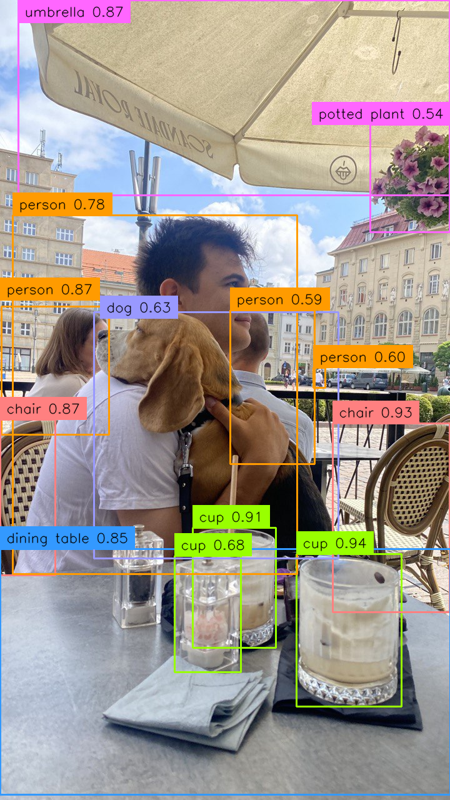

In [ ]:
import numpy as np
import supervision as sv

from PIL import Image

from rfdetr import RFDETRMedium
from rfdetr.util.coco_classes import COCO_CLASSES

image = Image.open("dog-2.jpeg")

model = RFDETRMedium(resolution=640)
model.optimize_for_inference()

detections = model.predict(image, threshold=0.5)

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    smart_position=True
)

labels = [
    f"{COCO_CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = bbox_annotator.annotate(annotated_image, detections)
annotated_image = label_annotator.annotate(annotated_image, detections, labels)
annotated_image.thumbnail((800, 800))
annotated_image

## Download Dataset from Roboflow Universe

RF-DETR expects the dataset to be in COCO format. Divide your dataset into three subdirectories: `train`, `valid`, and `test`. Each subdirectory should contain its own `_annotations.coco.json` file that holds the annotations for that particular split, along with the corresponding image files. Below is an example of the directory structure:

```
dataset/
├── train/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
├── valid/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
└── test/
    ├── _annotations.coco.json
    ├── image1.jpg
    ├── image2.jpg
    └── ... (other image files)
```

[Roboflow](https://roboflow.com/annotate) allows you to create object detection datasets from scratch or convert existing datasets from formats like YOLO, and then export them in COCO JSON format for training. You can also explore [Roboflow Universe](https://universe.roboflow.com/) to find pre-labeled datasets for a range of use cases.

In [ ]:
from roboflow import download_dataset

dataset = download_dataset("https://universe.roboflow.com/roboflow-jvuqo/basketball-player-detection-2/13", "coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to basketball-player-detection-2-13 in coco:: 100%|██████████| 1406/1406 [00:00<00:00, 4046.39it/s]


## Train RF-DETR on custom dataset

### Choose the right `batch_size`

Different GPUs have different amounts of VRAM (video memory), which limits how much data they can handle at once during training. To make training work well on any machine, you can adjust two settings: `batch_size` and `grad_accum_steps`. These control how many samples are processed at a time. The key is to keep their product equal to 16 — that’s our recommended total batch size. For example, on powerful GPUs like the A100, set `batch_size=16` and `grad_accum_steps=1`. On smaller GPUs like the T4, use `batch_size=4` and `grad_accum_steps=4`. We use a method called gradient accumulation, which lets the model simulate training with a larger batch size by gradually collecting updates before adjusting the weights.

In [ ]:
from rfdetr import RFDETRNano

model = RFDETRNano()

model.train(dataset_dir=dataset.location, epochs=10, batch_size=8, grad_accum_steps=2)

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights
Failed to load pretrain weights: PytorchStreamReader failed reading zip archive: failed finding central directory
Failed to load pretrain weights, re-downloading


rf-detr-nano.pth: 100%|██████████| 349M/349M [00:16<00:00, 22.1MiB/s]


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=6, grad_accum_steps=2, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=8, weight_decay=0.0001, epochs=10, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-nano.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=2, dim_feedforward=2048, hidden_dim=256, sa_nheads=8, ca_nheads=1

Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an erro

Epoch: [0]  [ 0/65]  eta: 0:02:21  lr: 0.000100  class_error: 93.83  loss: 7.6190 (7.6190)  loss_ce: 1.1873 (1.1873)  loss_bbox: 0.3462 (0.3462)  loss_giou: 0.9597 (0.9597)  loss_ce_0: 1.1472 (1.1472)  loss_bbox_0: 0.3870 (0.3870)  loss_giou_0: 0.9851 (0.9851)  loss_ce_enc: 1.2261 (1.2261)  loss_bbox_enc: 0.3759 (0.3759)  loss_giou_enc: 1.0045 (1.0045)  loss_ce_unscaled: 1.1873 (1.1873)  class_error_unscaled: 93.8344 (93.8344)  loss_bbox_unscaled: 0.0692 (0.0692)  loss_giou_unscaled: 0.4799 (0.4799)  cardinality_error_unscaled: 3882.2500 (3882.2500)  loss_ce_0_unscaled: 1.1472 (1.1472)  loss_bbox_0_unscaled: 0.0774 (0.0774)  loss_giou_0_unscaled: 0.4925 (0.4925)  cardinality_error_0_unscaled: 3883.6250 (3883.6250)  loss_ce_enc_unscaled: 1.2261 (1.2261)  loss_bbox_enc_unscaled: 0.0752 (0.0752)  loss_giou_enc_unscaled: 0.5023 (0.5023)  cardinality_error_enc_unscaled: 3883.6250 (3883.6250)  time: 2.1773  data: 0.6572  max mem: 3708
Epoch: [0]  [10/65]  eta: 0:00:52  lr: 0.000100  class_er

Mean of empty slice
Mean of empty slice
Mean of empty slice


Test:  [ 0/24]  eta: 0:00:12  class_error: 5.81  loss: 4.2541 (4.2541)  loss_ce: 0.6016 (0.6016)  loss_bbox: 0.1197 (0.1197)  loss_giou: 0.6705 (0.6705)  loss_ce_0: 0.6289 (0.6289)  loss_bbox_0: 0.1279 (0.1279)  loss_giou_0: 0.6642 (0.6642)  loss_ce_enc: 0.6172 (0.6172)  loss_bbox_enc: 0.1327 (0.1327)  loss_giou_enc: 0.6914 (0.6914)  loss_ce_unscaled: 0.6016 (0.6016)  class_error_unscaled: 5.8065 (5.8065)  loss_bbox_unscaled: 0.0239 (0.0239)  loss_giou_unscaled: 0.3353 (0.3353)  cardinality_error_unscaled: 243.2500 (243.2500)  loss_ce_0_unscaled: 0.6289 (0.6289)  loss_bbox_0_unscaled: 0.0256 (0.0256)  loss_giou_0_unscaled: 0.3321 (0.3321)  cardinality_error_0_unscaled: 239.3750 (239.3750)  loss_ce_enc_unscaled: 0.6172 (0.6172)  loss_bbox_enc_unscaled: 0.0265 (0.0265)  loss_giou_enc_unscaled: 0.3457 (0.3457)  cardinality_error_enc_unscaled: 247.8750 (247.8750)  time: 0.5350  data: 0.2424  max mem: 5119
Test:  [10/24]  eta: 0:00:04  class_error: 3.74  loss: 4.2631 (4.3037)  loss_ce: 0.60

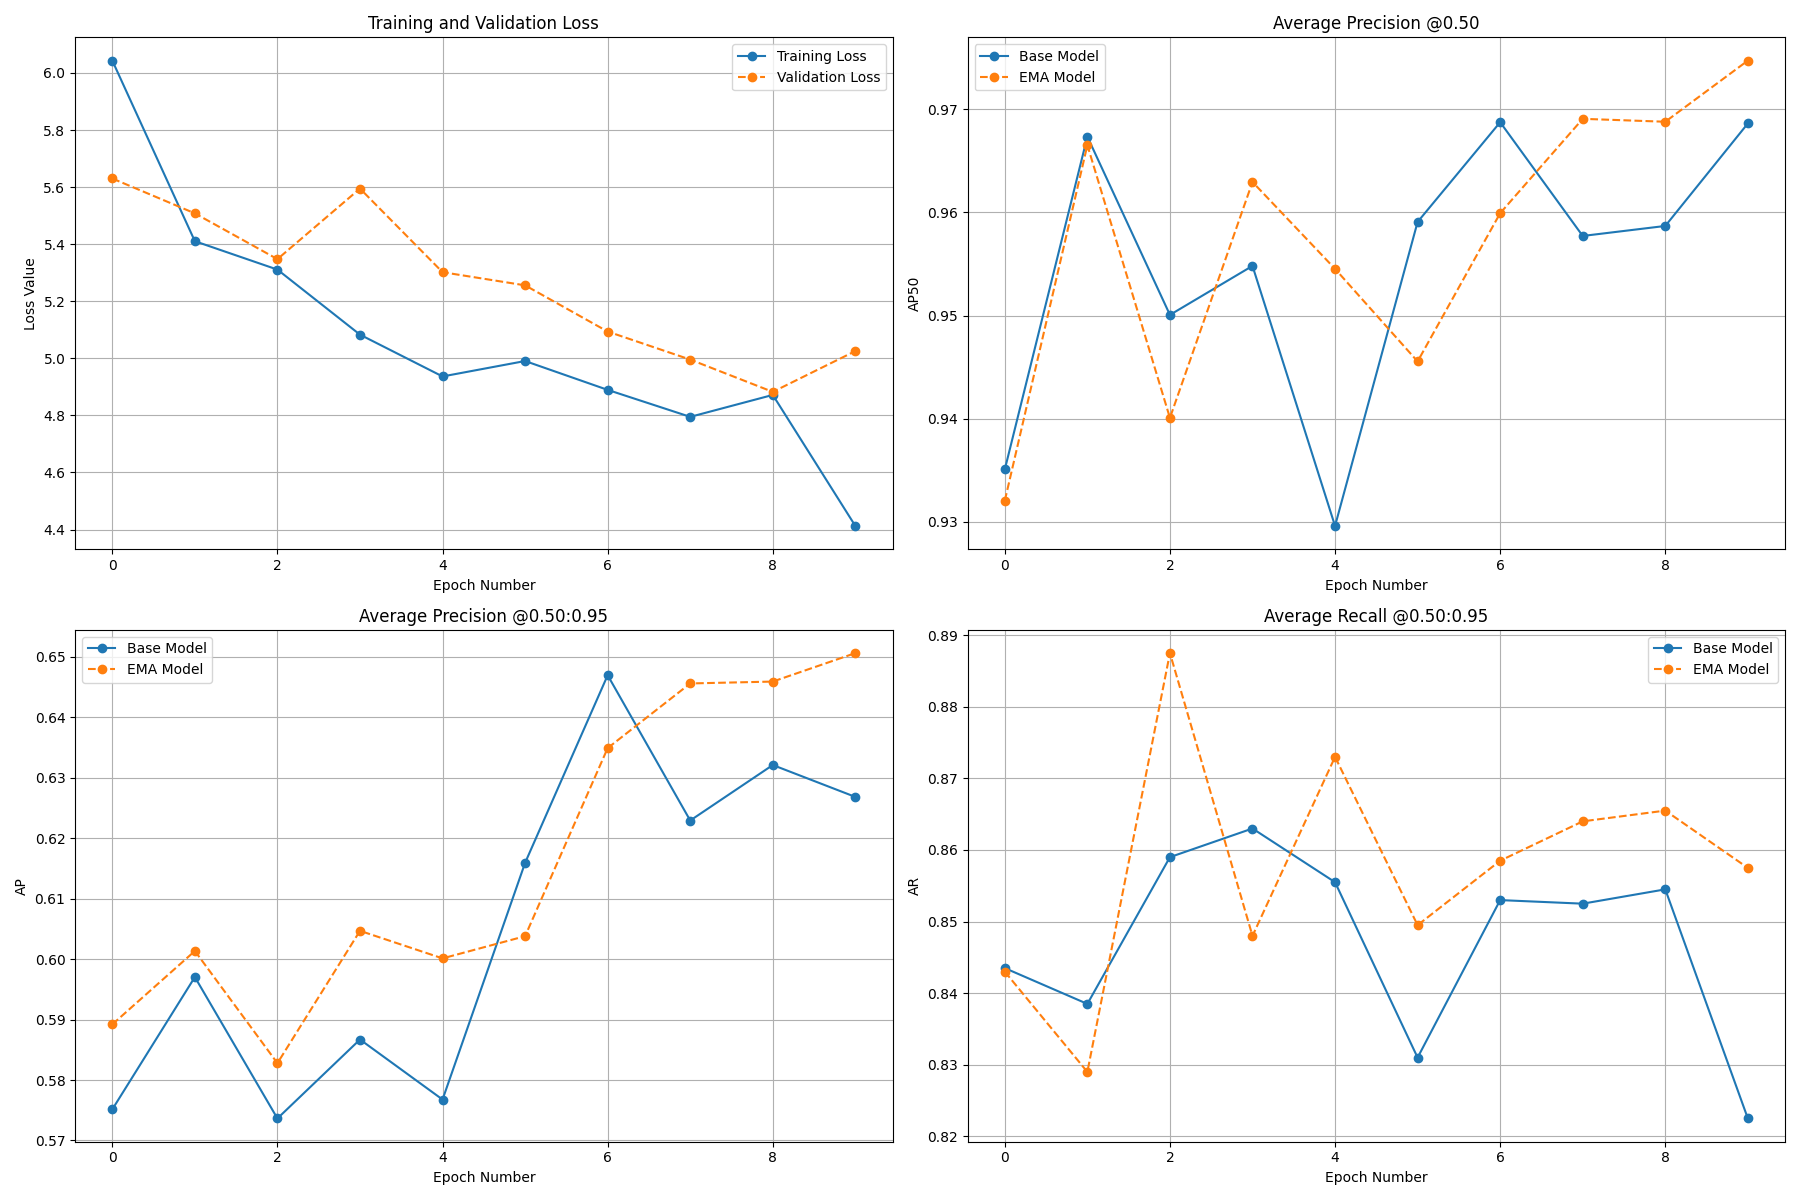

In [3]:
from PIL import Image

Image.open("/content/output/metrics_plot.png")

In [ ]:
!ls -la /content/output

total 1774316
drwxr-xr-x 3 root root      4096 Jan 22 19:33 .
drwxr-xr-x 1 root root      4096 Jan 22 19:21 ..
-rw-r--r-- 1 root root 484664813 Jan 22 19:33 checkpoint0009.pth
-rw-r--r-- 1 root root 362610474 Jan 22 19:33 checkpoint_best_ema.pth
-rw-r--r-- 1 root root 363841030 Jan 22 19:33 checkpoint_best_regular.pth
-rw-r--r-- 1 root root 120840095 Jan 22 19:33 checkpoint_best_total.pth
-rw-r--r-- 1 root root 484655501 Jan 22 19:33 checkpoint.pth
drwxr-xr-x 2 root root      4096 Jan 22 19:22 eval
-rw-r--r-- 1 root root      4412 Jan 22 19:33 events.out.tfevents.1769109679.cc039bb6718a.2442.0
-rw-r--r-- 1 root root     62193 Jan 22 19:33 log.txt
-rw-r--r-- 1 root root    173403 Jan 22 19:33 metrics_plot.png
-rw-r--r-- 1 root root      1874 Jan 22 19:33 results.json


## Deploy a Trained RF-DETR Model

Deploying to Roboflow allows you to create multi-step computer vision applications that run both in the cloud and your own hardware. Please wait a moment while Roboflow indexes your model.

In [ ]:
model.deploy_to_roboflow(
  workspace="roboflow-jvuqo",
  project_id="basketball-player-detection-2",
  version=13,
  api_key=os.environ["ROBOFLOW_API_KEY"]
)

loading Roboflow workspace...
loading Roboflow project...
View the status of your deployment at: https://app.roboflow.com/roboflow-jvuqo/basketball-player-detection-2/13
Share your model with the world at: https://universe.roboflow.com/roboflow-jvuqo/basketball-player-detection-2/model/13


## Evaluate Fine-tuned RF-DETR Model

Before benchmarking the model, we need to load the best saved checkpoint. To ensure it fits on the GPU, we first need to free up GPU memory. This involves deleting any remaining references to previously used objects, triggering Python’s garbage collector, and clearing the CUDA memory cache.

In [5]:
import gc
import torch
import weakref

def cleanup_gpu_memory(obj=None, verbose: bool = False):

    if not torch.cuda.is_available():
        if verbose:
            print("[INFO] CUDA is not available. No GPU cleanup needed.")
        return

    def get_memory_stats():
        allocated = torch.cuda.memory_allocated()
        reserved = torch.cuda.memory_reserved()
        return allocated, reserved

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[Before] Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

    # Ensure we drop all strong references
    if obj is not None:
        ref = weakref.ref(obj)
        del obj
        if ref() is not None and verbose:
            print("[WARNING] Object not fully garbage collected yet.")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[After]  Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

In [6]:
cleanup_gpu_memory(model, verbose=True)

[Before] Allocated: 372.22 MB | Reserved: 4498.00 MB
[WARNING] Object not fully garbage collected yet.
[After]  Allocated: 255.17 MB | Reserved: 364.00 MB


We load the best-performing model from the `checkpoint_best_total.pth` file using the `RFDETRMedium` class. This checkpoint contains the trained weights from our most successful training run. After loading, we call `optimize_for_inference()`, which prepares the model for efficient inference.

In [10]:
model = RFDETRNano(pretrain_weights="/content/output/checkpoint_best_total.pth")
# model.optimize_for_inference()

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


In [8]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"/content/arcade_coco_dataset/test",
    annotations_path=f"/content/arcade_coco_dataset/test/_annotations.coco.json",
)

In [9]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0)

    targets.append(annotations)
    predictions.append(detections)

  0%|          | 0/300 [00:00<?, ?it/s]


ValueError: Invalid image shape. Expected 3 channels (RGB), but got 1 channels.

In [ ]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
print(map_result)

Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.446
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.770
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.436
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.213
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.691
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.842


In [11]:
import supervision as sv
from tqdm import tqdm
from PIL import Image

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    # Załaduj obraz
    image = Image.open(path)

    # ✅ KONWERTUJ DO RGB (nawet jeśli już jest RGB, to nie szkodzi)
    image = image.convert('RGB')

    # Predykcja
    detections = model.predict(image, threshold=0)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 300/300 [00:18<00:00, 15.79it/s]


## Training for segmentation

In [14]:
import json
import numpy as np
from PIL import Image
import supervision as sv
from torch_arcade import ARCADEBinarySegmentation
import os
from pycocotools import mask as mask_utils

output_root_dir = "arcade_coco_dataset_seg"
os.makedirs(output_root_dir, exist_ok=True)

for split in ["train", "valid", "test"]:
    split_path = os.path.join(output_root_dir, split)
    os.makedirs(split_path, exist_ok=True)

print(f"Created directory structure under: {output_root_dir}")

# SEGMENTACJA: Kategorie dla modelu segmentacyjnego
categories = [
    {"id": 1, "name": "segmentation_target", "supercategory": "object"}
]
print("Defined COCO categories for segmentation.")

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

def mask_to_polygon(mask):
    """
    Konwertuje binarną maskę na format polygon COCO (lista współrzędnych).
    """
    # Znajdź kontury w masce
    contours = []
    # Konwersja na uint8
    mask_uint8 = mask.astype(np.uint8)

    # Użyj opencv do znalezienia konturów (opcjonalnie)
    # Jeśli nie masz opencv, użyj pycocotools
    try:
        import cv2
        contours_cv, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        polygons = []
        for contour in contours_cv:
            if contour.size >= 6:  # Co najmniej 3 punkty (x,y pary)
                contour = contour.flatten().tolist()
                polygons.append(contour)
        return polygons if polygons else [[]]
    except ImportError:
        # Fallback: użyj RLE i konwersji z powrotem
        # Dla prostoty, zwróć RLE jako alternatywę
        return mask_to_rle(mask)

def mask_to_rle(mask):
    """Konwertuje binarną maskę do formatu RLE zgodnego z COCO."""
    mask = np.asfortranarray(mask.astype(np.uint8))
    rle = mask_utils.encode(mask)
    rle['counts'] = rle['counts'].decode('utf-8')
    return rle

def convert_mask_to_bbox(mask):
    """Oblicza bounding box z binarnej maski w formacie COCO [x, y, width, height]."""
    y_coords, x_coords = np.where(mask > 0)

    if len(x_coords) == 0 or len(y_coords) == 0:
        return [0, 0, 0, 0]

    x_min = int(np.min(x_coords))
    y_min = int(np.min(y_coords))
    x_max = int(np.max(x_coords))
    y_max = int(np.max(y_coords))

    width = x_max - x_min + 1
    height = y_max - y_min + 1

    return [x_min, y_min, width, height]

for split_name in ["train", "valid", "test"]:
    print(f"\nProcessing {split_name} split...")

    arcade_image_set = split_name if split_name != "valid" else "val"

    current_dataset = ARCADEBinarySegmentation(
        "dataset/",
        image_set=arcade_image_set,
        download=False
    )

    coco_images = []
    coco_annotations = []
    annotation_id_counter = 0
    image_id_counter = 0
    images_without_objects = 0

    for i, (img, mask) in enumerate(current_dataset):
        image_id_counter += 1
        img_width, img_height = img.size
        image_filename = f"{image_id_counter:06d}.jpg"
        image_path = os.path.join(output_root_dir, split_name, image_filename)

        # Zapisz obraz
        img.save(image_path)

        coco_images.append({
            "id": image_id_counter,
            "width": img_width,
            "height": img_height,
            "file_name": image_filename
        })

        # SEGMENTACJA: Używamy polygon zamiast tylko bbox
        if np.any(mask):
            binary_mask = (mask > 0).astype(np.uint8)
            bbox = convert_mask_to_bbox(binary_mask)
            area = int(np.sum(binary_mask))

            if area > 0 and bbox[2] > 0 and bbox[3] > 0:
                try:
                    # Dla segmentacji potrzebujemy polygon lub RLE
                    # RF-DETR akceptuje oba formaty
                    polygons = mask_to_polygon(binary_mask)

                    # Jeśli mask_to_polygon zwraca RLE (gdy opencv niedostępne)
                    if isinstance(polygons, dict):
                        segmentation = polygons
                    else:
                        segmentation = polygons

                    annotation_id_counter += 1

                    coco_annotations.append({
                        "id": annotation_id_counter,
                        "image_id": image_id_counter,
                        "category_id": 1,  # segmentation_target
                        "segmentation": segmentation,
                        "area": area,
                        "bbox": bbox,
                        "iscrowd": 0
                    })
                except Exception as e:
                    print(f"Warning: Failed to encode mask for image {image_id_counter}: {e}")
            else:
                images_without_objects += 1
        else:
            images_without_objects += 1

    coco_json = {
        "images": coco_images,
        "annotations": coco_annotations,
        "categories": categories
    }

    output_annotation_path = os.path.join(output_root_dir, split_name, "_annotations.coco.json")

    with open(output_annotation_path, "w") as f:
        json.dump(coco_json, f, indent=4, cls=NpEncoder)

    print(f"✓ Saved {len(coco_images)} images and {len(coco_annotations)} annotations")
    print(f"  Images without objects: {images_without_objects}")

print("\n✓ COCO-formatted dataset for SEGMENTATION complete.")



Created directory structure under: arcade_coco_dataset_seg
Defined COCO categories for segmentation.

Processing train split...
loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
✓ Saved 1000 images and 1000 annotations
  Images without objects: 0

Processing valid split...
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
✓ Saved 200 images and 200 annotations
  Images without objects: 0

Processing test split...
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
✓ Saved 300 images and 300 annotations
  Images without objects: 0

✓ COCO-formatted dataset for SEGMENTATION complete.


In [16]:
import rfdetr
print(dir(rfdetr))

['RFDETRBase', 'RFDETRLarge', 'RFDETRMedium', 'RFDETRNano', 'RFDETRSegPreview', 'RFDETRSmall', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'config', 'datasets', 'detr', 'engine', 'main', 'models', 'os', 'util']


In [18]:
import torch
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [22]:
!pip install git+https://github.com/roboflow/rf-detr.git

  Cloning https://github.com/roboflow/rf-detr.git to /tmp/pip-req-build-2j1dyspe
  Running command git clone --filter=blob:none --quiet https://github.com/roboflow/rf-detr.git /tmp/pip-req-build-2j1dyspe
  Resolved https://github.com/roboflow/rf-detr.git to commit 35ac6ab64634e188bbb0fa3fc5135132f0df45fc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached torch-2.8.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached nvidia_nccl_cu12-2.27.3-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.0 kB)
  Using cached triton-3.4.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (1.7 kB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
  Using cached torchvision-0.25.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.4 kB)
  Using cached torch

In [1]:
# ===== TRENING MODELU SEGMENTACYJNEGO =====
from rfdetr import RFDETRSegNano  # Możesz też użyć RFDETRSegSmall, RFDETRSegMedium, etc.

# Inicjalizacja modelu segmentacyjnego
model = RFDETRSegNano(load_pretrain=False, pretrained_weights=None)

# Trening
model.train(
    dataset_dir="/content/arcade_coco_dataset_seg",
    epochs=8,
    batch_size=4,
    grad_accum_steps=4,
    lr=1e-4,
    output_dir="output_segmentation"
)

print("\n✓ Training complete!")

rf-detr-seg-nano.pt: 100%|██████████| 128M/128M [00:01<00:00, 100MiB/s] 


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 12 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir /content/output_segmentation' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=2, grad_accum_steps=4, print_freq=10, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=8, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-seg-nano.pt', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=4, dim_feedforward=2048, h

Epoch: [0]  [ 0/62]  eta: 0:06:29  lr: 0.000100  class_error: 0.00  loss: 65.3272 (65.3272)  loss_ce: 5.9053 (5.9053)  loss_bbox: 1.1218 (1.1218)  loss_giou: 0.4892 (0.4892)  loss_mask_ce: 1.7438 (1.7438)  loss_mask_dice: 3.0576 (3.0576)  loss_ce_0: 4.7726 (4.7726)  loss_bbox_0: 2.5175 (2.5175)  loss_giou_0: 0.8925 (0.8925)  loss_mask_ce_0: 2.1233 (2.1233)  loss_mask_dice_0: 3.1327 (3.1327)  loss_ce_1: 5.3765 (5.3765)  loss_bbox_1: 1.7588 (1.7588)  loss_giou_1: 0.6870 (0.6870)  loss_mask_ce_1: 2.1241 (2.1241)  loss_mask_dice_1: 3.1941 (3.1941)  loss_ce_2: 5.7411 (5.7411)  loss_bbox_2: 1.2510 (1.2510)  loss_giou_2: 0.5539 (0.5539)  loss_mask_ce_2: 1.9808 (1.9808)  loss_mask_dice_2: 3.1008 (3.1008)  loss_ce_enc: 4.1025 (4.1025)  loss_bbox_enc: 3.4189 (3.4189)  loss_giou_enc: 1.1129 (1.1129)  loss_mask_ce_enc: 2.0259 (2.0259)  loss_mask_dice_enc: 3.1424 (3.1424)  loss_ce_unscaled: 1.1811 (1.1811)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.2244 (0.2244)  loss_giou_unscal

RuntimeError: selected index k out of range

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

from rfdetr import RFDETRSegPreview

# ✅ ZAŁADUJ PRETRAINED MODEL
model = RFDETRSegPreview(
    load_pretrain=True,  # ✅ Załaduj wagi pretrained
    pretrained_weights="rf-detr-seg-preview.pt"  # Domyślna wartość
)

model.train(
    dataset_dir="/content/arcade_coco_dataset_seg",
    epochs=8,
    batch_size=1,
    grad_accum_steps=16,
    lr=1e-4,
    output_dir="output_segmentation"
)

print("\n✅ Training complete!")

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 12 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir /content/output_segmentation' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=2, grad_accum_steps=16, print_freq=10, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=1, weight_decay=0.0001, epochs=8, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-seg-preview.pt', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=4, dim_feedforward=204

Epoch: [0]  [ 0/62]  eta: 0:08:07  lr: 0.000100  class_error: 0.00  loss: 69.5468 (69.5468)  loss_ce: 4.9456 (4.9456)  loss_bbox: 1.5177 (1.5177)  loss_giou: 0.7688 (0.7688)  loss_mask_ce: 2.2783 (2.2783)  loss_mask_dice: 3.8805 (3.8805)  loss_ce_0: 4.7380 (4.7380)  loss_bbox_0: 1.7110 (1.7110)  loss_giou_0: 0.9224 (0.9224)  loss_mask_ce_0: 1.6432 (1.6432)  loss_mask_dice_0: 4.5030 (4.5030)  loss_ce_1: 4.9541 (4.9541)  loss_bbox_1: 1.5977 (1.5977)  loss_giou_1: 0.8213 (0.8213)  loss_mask_ce_1: 2.5005 (2.5005)  loss_mask_dice_1: 4.0415 (4.0415)  loss_ce_2: 5.3885 (5.3885)  loss_bbox_2: 1.1512 (1.1512)  loss_giou_2: 0.6406 (0.6406)  loss_mask_ce_2: 2.3944 (2.3944)  loss_mask_dice_2: 3.9507 (3.9507)  loss_ce_enc: 4.8515 (4.8515)  loss_bbox_enc: 1.4650 (1.4650)  loss_giou_enc: 0.8948 (0.8948)  loss_mask_ce_enc: 3.4928 (3.4928)  loss_mask_dice_enc: 4.4937 (4.4937)  loss_ce_unscaled: 0.9891 (0.9891)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.3035 (0.3035)  loss_giou_unscal

## Run Inference with Fine-tuned RF-DETR Model

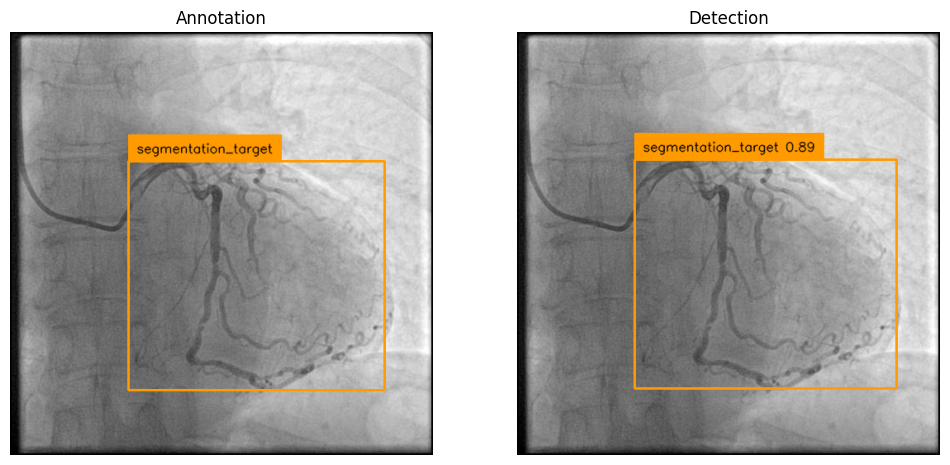

In [13]:
from rfdetr import RFDETRBase
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path).convert('RGB')

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

bbox_annotator = sv.BoxAnnotator(color=color,thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

In [ ]:
!pip install -q inference

In [ ]:
from inference import get_model

MODEL_ID = "basketball-player-detection-2/13"
model_rf = get_model(model_id=MODEL_ID, api_key = userdata.get("ROBOFLOW_API_KEY"))

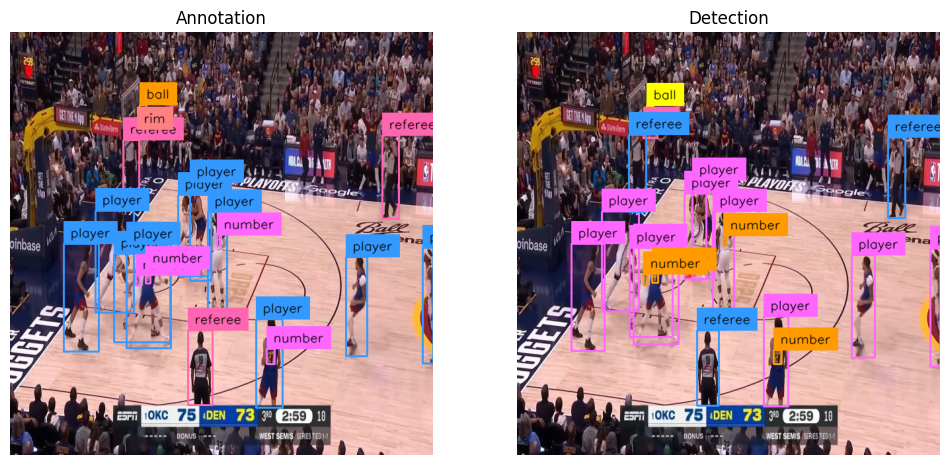

In [ ]:
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

result = model_rf.infer(image, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

bbox_annotator = sv.BoxAnnotator(color=color,thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

<div align="center">
  <p>
    Looking for more tutorials or have questions?
    Check out our <a href="https://github.com/roboflow/notebooks">GitHub repo</a> for more notebooks,
    or visit our <a href="https://discord.gg/GbfgXGJ8Bk">discord</a>.
  </p>
  
  <p>
    <strong>If you found this helpful, please consider giving us a ⭐
    <a href="https://github.com/roboflow/notebooks">on GitHub</a>!</strong>
  </p>

</div>